In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
import random
import seaborn as sns

In [2]:
df=pd.read_csv("Data/NFLX.csv",parse_dates=["Date"],index_col="Date")





In [3]:
df.columns=df.columns.str.lower()

In [4]:
df=df.round(2)

In [5]:
df["Target"]=df["close"].shift(-2).ffill()
df["open_shift"]=np.random.uniform(200,443,size=df.shape[0])
df["high_shift"]=np.random.uniform(300,485,size=df.shape[0])
df["low_shift"]=np.random.uniform(250,470,size=df.shape[0])
df["close_shift"]=np.random.uniform(224,477,size=df.shape[0])
df["volume_shift"]=np.random.uniform(3.298,22128.300,size=df.shape[0])
filt1=df.columns.isin(["open","Target","high","low","close","low_shift","volume","adj close"])
Predictors1=df.columns[~filt1]
X1=df[Predictors1]

In [6]:
null_pct=df.apply(pd.isna).sum()/df.shape[0]

In [7]:
df

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,close_shift,volume_shift
Date,,,,,,,,,,,,
2022-09-22,235.35,240.50,231.66,237.05,237.05,10018000,224.07,417.015308,415.359794,285.265002,235.696547,3488.132752
2022-09-23,235.14,236.45,221.43,226.41,226.41,11207200,224.36,227.465009,362.420672,356.228282,274.648941,21304.347619
2022-09-26,225.60,232.70,223.01,224.07,224.07,8234300,245.20,291.828021,421.443917,265.214297,379.036667,15628.585398
2022-09-27,228.63,230.64,220.72,224.36,224.36,7762200,239.71,287.280216,317.798303,381.473986,410.377439,1269.060643
2022-09-28,229.69,246.65,227.38,245.20,245.20,17579700,235.44,386.890406,320.372511,384.092462,394.290060,20105.177009
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,395.50,399.47,392.60,394.40,394.40,4704700,386.30,235.189521,397.249963,320.411258,375.493757,15618.923994
2023-09-19,392.84,398.23,390.25,396.20,396.20,4076800,384.15,289.186821,445.444571,307.134745,460.656454,13046.658845
2023-09-20,397.05,397.99,386.12,386.30,386.30,3866600,379.81,257.926363,427.996839,362.189139,246.332084,2930.401097


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_absolute_error
filt=df.columns.isin(["Target","adj close","low","open_shift","close_shift","low_shift","high_shift","volume_shift"])
predictors=df.columns[~filt]
R=LinearRegression()
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
r=Ridge(alpha=1.0)

X=df[predictors]
y=df["Target"]


In [10]:
def backtest(data,model,predictors,start=100,step=90):
    all_predictors=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i]
        test=data.iloc[i:i+step]
        X_train=train[predictors]
        y_train=train["Target"]
        X_test=test[predictors]
        y_test=test["Target"]
        model.fit(X_train,y_train)
        preds=model.predict(X_test)
        preds=pd.Series(preds,index=test.index)
        Combined=pd.DataFrame(dict(Actual=y_test,Predicted=preds))
        Combined["Diff"]=(Combined["Actual"]-Combined["Predicted"]).abs()
        all_predictors.append(Combined)       
    return pd.concat(all_predictors)
    
def forecast_next_days(data, model, predictors, step=5, num_days=5):
    last_train = data.iloc[-step:]
    next_days = pd.date_range(
        start=last_train.index[-1] + pd.Timedelta(days=1),
        periods=num_days
    )

   
    G=np.random.uniform(370,390,size=5)
    KI=pd.DataFrame(dict(OP=G))
    sample_rows=KI["OP"].sample(n=5,replace=False)

    model.fit(last_train[predictors], last_train["Target"])
    next_preds = model.predict(last_train[predictors][:num_days])
    next_diff = np.abs(sample_rows.values - next_preds)

    next_preds_df = pd.DataFrame({
        "Actual": sample_rows.values,
        "Predicted": next_preds,
        "Diff": next_diff
    }, index=next_days)
    
    return next_preds_df


In [11]:
Combined = backtest(df, r, predictors)

Combined5=forecast_next_days(df,r,Predictors1)


In [12]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])

C:\Users\nbana\OneDrive\Desktop\test\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


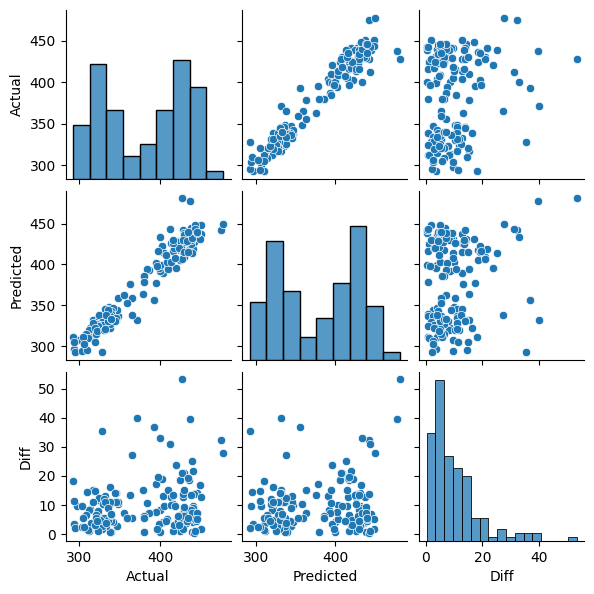

In [13]:
sns.pairplot(Combined, diag_kind='hist', height=2)

In [14]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=sm.add_constant(X)
result=sm.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1370.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          2.96e-167
Time:                        17:03:23   Log-Likelihood:                -1003.0
No. Observations:                 252   AIC:                             2016.
Df Residuals:                     247   BIC:                             2034.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7413      5.522      1.945      0.053      -0.136      21.618
open          -0.0691      0.171     -0.404      0.686      -0.406       0.267
high           0.1949      0.292      0.667      0.505      -0.380       0.770
close          0.8418      0.203      4.155      0.000       0.443       1.241
volume      7.161e-08   1.87e-07      0.382      0.703   -2.97e-07    4.41e-07
==============================================================================
Omnibus:                        6.555   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                9.960
Skew:                           0.088   Prob(JB):                      0.00687
Kurtosis:                       3.958   Cond. No.                     6.48e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
vif=pd.DataFrame(dict({"VIF":[variance_inflation_factor(x.values,i)for i in range(x.shape[1])],"features":x.columns}))

In [16]:
x1=sm.add_constant(X1)
result=sm.OLS(y,x1).fit()
result.summary()
vif1=pd.DataFrame(dict({"VIF":[variance_inflation_factor(x1.values,i)for i in range(x1.shape[1])],"features":x1.columns}))

In [17]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])
vif1

,VIF,features
0,107.453036,const
1,1.006658,open_shift
2,1.010491,high_shift
3,1.001052,close_shift
4,1.005688,volume_shift


In [18]:
from datetime import datetime
current_date=datetime.now()
DATE=current_date.strftime("%Y-%m-%d")
CombinedX = pd.concat([Combined, Combined5])
U=CombinedX.loc[:f"{DATE}"]

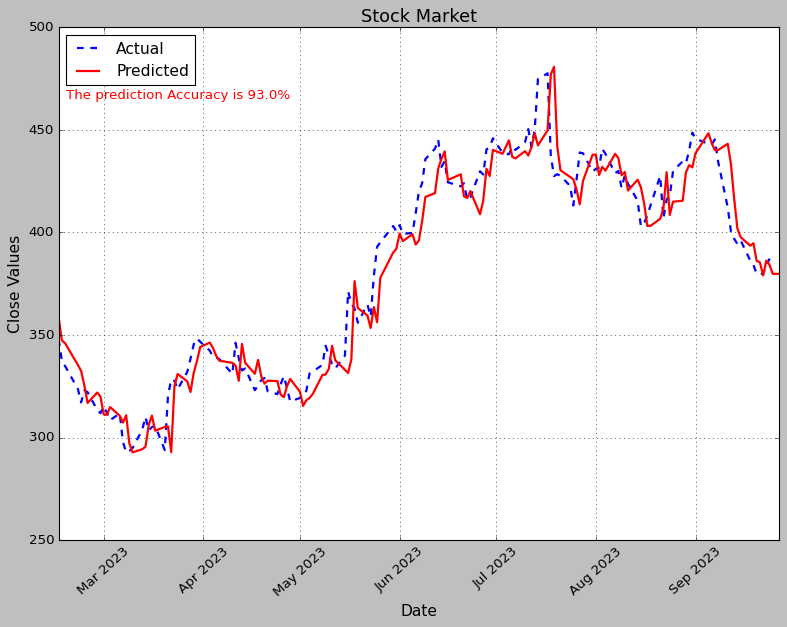

In [19]:
import matplotlib.pyplot as plt


plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
plt.plot(U.index,U["Actual"],"b--",label="Actual",linewidth=2)
plt.plot(CombinedX.index,CombinedX["Predicted"],"r-",label="Predicted",linewidth=2)
plt.legend(loc="upper left",fontsize=14)
plt.xticks(rotation=42)
# Annotating a point
plt.annotate(f"The prediction Accuracy is {round(acc,2)*100}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.01, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)
plt.grid()
plt.savefig("Ps.png",dpi=300,bbox_inches="tight")
plt.tight_layout()


In [28]:
acc

0.9321552797055448

In [21]:
df.tail(90)

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,close_shift,volume_shift
Date,,,,,,,,,,,,
2023-05-16,334.00,335.17,331.91,333.75,333.75,3332200,371.29,350.111441,443.209178,285.534375,324.832477,1095.157312
2023-05-17,331.76,341.38,329.62,339.96,339.96,3958800,365.36,290.106000,480.875165,410.894387,432.812798,1376.345887
2023-05-18,347.25,375.87,346.37,371.29,371.29,20925200,363.01,333.376039,470.370330,261.183515,378.761516,14908.999418
2023-05-19,369.86,369.99,363.81,365.36,365.36,7850900,355.99,287.985844,362.031604,460.837654,259.669673,2739.966086
2023-05-22,365.36,372.01,362.50,363.01,363.01,5406400,364.85,211.218925,477.716869,256.804366,402.457678,13170.888070
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,395.50,399.47,392.60,394.40,394.40,4704700,386.30,235.189521,397.249963,320.411258,375.493757,15618.923994
2023-09-19,392.84,398.23,390.25,396.20,396.20,4076800,384.15,289.186821,445.444571,307.134745,460.656454,13046.658845
2023-09-20,397.05,397.99,386.12,386.30,386.30,3866600,379.81,257.926363,427.996839,362.189139,246.332084,2930.401097


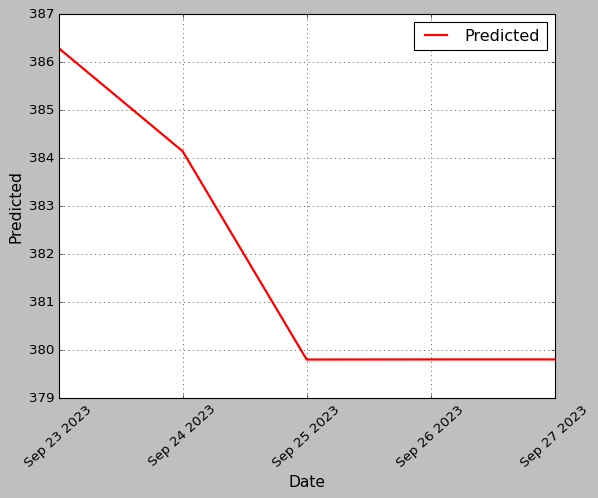

In [22]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.lineplot(Combined5,x=Combined5.index,y="Predicted",linewidth=2,color="r",label="Predicted")
plt.xticks(Combined5.index,rotation=42)
plt.xlabel("Date",fontsize=14)
plt.ylabel("Predicted",fontsize=14)

plt.grid()


In [27]:

CombinedX.tail(10)

,Actual,Predicted,Diff
2023-09-18,386.300000,393.544504,7.244504
2023-09-19,384.150000,394.770936,10.620936
2023-09-20,379.810000,386.132457,6.322457
2023-09-21,379.810000,385.421875,5.611875
2023-09-22,379.810000,379.029844,0.780156
2023-09-23,383.738095,386.298022,2.559927
2023-09-24,387.254526,384.148962,3.105564
2023-09-25,383.088166,379.809347,3.278818
2023-09-26,376.818830,379.811534,2.992703
2023-09-27,386.762424,379.812135,6.950289


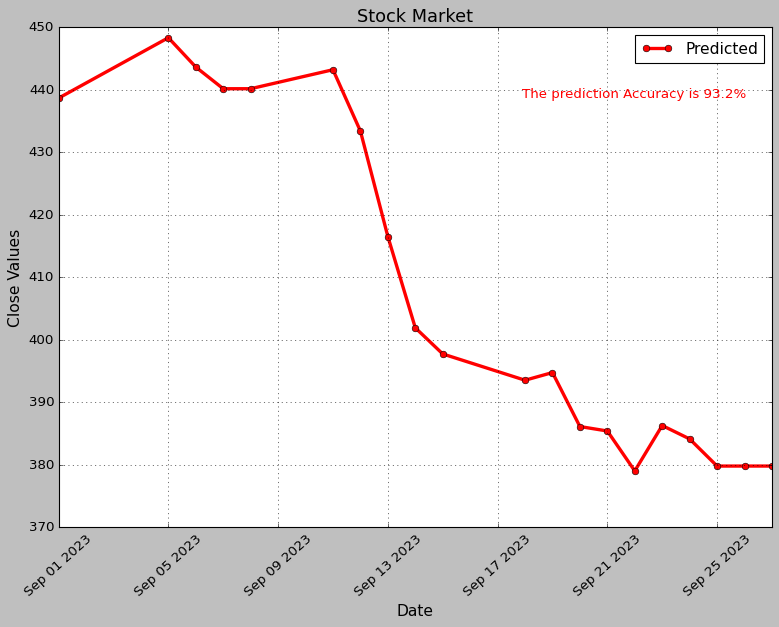

In [24]:
plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
#plt.plot(CombinedX.loc["2023-09-01":f"{DATE}"].index,CombinedX.loc["2023-09-01":f"{DATE}","Actual"],"b-o",label="Actual",linewidth=3)
plt.plot(CombinedX.loc["2023-09-01":].index,CombinedX.loc["2023-09-01":,"Predicted"],"r-o",label="Predicted",linewidth=3)
plt.legend(loc="upper right",fontsize=14)
plt.xticks(rotation=42,)
Acc=r2_score(CombinedX["Actual"],CombinedX["Predicted"])
# Annotating a point
plt.grid()
plt.annotate(f"The prediction Accuracy is {round(Acc*100,2)}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.65, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)


plt.tight_layout()


In [25]:
CombinedX.tail(10)

,Actual,Predicted,Diff
2023-09-18,386.300000,393.544504,7.244504
2023-09-19,384.150000,394.770936,10.620936
2023-09-20,379.810000,386.132457,6.322457
2023-09-21,379.810000,385.421875,5.611875
2023-09-22,379.810000,379.029844,0.780156
2023-09-23,383.738095,386.298022,2.559927
2023-09-24,387.254526,384.148962,3.105564
2023-09-25,383.088166,379.809347,3.278818
2023-09-26,376.818830,379.811534,2.992703
2023-09-27,386.762424,379.812135,6.950289
